# Tree Analysis 

In [59]:
from __future__ import division 

%load_ext memory_profiler
%matplotlib inline

import os
import re
import sys
import graph_tool.all as gt

from operator import itemgetter
from collections import namedtuple, defaultdict

# Modify the Notebook path
sys.path.append(os.path.join(os.getcwd(), ".."))

from cloudscope.results import Results

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [2]:
FIXTURES  = os.path.join("..", "fixtures")
RESULTS   = os.path.join(FIXTURES, "results")

# Results Files with log traces 
FEDERATED = os.path.join(RESULTS, "single", "federated-consistency-20160923.json")
RAFT      = os.path.join(RESULTS, "single", "large-consensus-group-20160923.json")
EVENTUAL  = os.path.join(RESULTS, "single", "eventually-consistent-large-group-20160923.json")

In [3]:
%%memit
def load_data(path=EVENTUAL):
    with open(path) as f:
        return Results.load(f) 
    
results = load_data()
trees = [log['log'] for log in results.consistency['logs'].values()]

peak memory: 167.86 MiB, increment: 57.52 MiB


In [87]:
ROOT    = u"root"
VERSRE  = re.compile(r'(root | ([A-Z]+)\.(\d+))->([A-Z]+)\.(\d+)', re.IGNORECASE | re.VERBOSE)
Version = namedtuple('Version', 'parent, name, version, children')

def parse_version(vers):
    """
    Parses a version string to get an element. 
    """
    match = VERSRE.match(vers) 
    if match is None:
        raise ValueError(
            "Could not parse '{}'".format(vers) 
        )
    
    root, pname, pid, cname, cid = match.groups() 
    
    pid = int(pid) if pid else 0 
    cid = int(cid) if cid else -1
    
    parent  = Version(None, cname, 0, []) if root == ROOT else Version(None, pname, pid, [])
    version = Version(parent, cname, cid, [])
    
    return version

def create_tree(log):
    """
    Constructs a tree from a given log. 
    """
    
    def find_version(vers, versions):
        for item in versions:
            if item.name == vers.name and item.version == vers.version:
                return item 
    
    # Parse the entries in the log 
    namespace = defaultdict(list)
    for entry in log: 
        version = parse_version(entry) 
        namespace[version.name].append(version)
        
    # Construct the Tree for each name in the namespace 
    for name in namespace.keys():
        versions = namespace[name]

        # Sort the versions by version number 
        versions.sort(key=itemgetter(2))
        
        # Add root version if it does not exist 
        if versions[0].version != 0:
            versions.insert(0, Version(ROOT, name, 0, []))
        
        # Create the list of heads to replace the namespace with 
        heads = [versions[0]]
    
        # Loop through everything but the first, root version. 
        for idx in xrange(1, len(versions)-1):
            version = versions[idx]
            
            # Find the parent if it exists. 
            parent = find_version(version.parent, versions)
            
            if parent: 
                # append the version to the parent 
                nv = version._replace(parent=parent)
                parent.children.append(nv)
                versions[idx] = nv 
                
                # remove the version from heads if it was there. 
                if version in heads: heads.remove(version) 
            else:
                heads.append(version)
    
        namespace[name] = heads 
    
    return namespace

In [88]:
ns = create_tree(trees[0])

In [89]:
def gt_info(g):
    """
    Prints out an info statement similar to networkx. 
    
        Name: Baleen Keyphrase Graph
        Type: Graph
        Number of nodes: 139227
        Number of edges: 257316
        Average degree:   3.6964
    
    Uses an simple format string to do this. 
    """
    
    # Set up the output
    output = []
        
    # Append the graph string properties 
    for key in g.gp.keys(): 
        output.append("{}: {}".format(key.title(), g.gp[key]))
    
    
    # Detect the graph type 
    graph_type = "DiGraph" if g.is_directed() else "Graph"
    output.append("Type: {}".format(graph_type))
    
    # Add the number of nodes and edges 
    output.append("Number of nodes: {:,}".format(g.num_vertices()))
    output.append("Number of edges: {:,}".format(g.num_edges()))
    
    # Add the average degree and standard deviation 
    output.append("Average degree:  {:0.3f}𝜇 {:0.3f}𝜎".format(*gt.vertex_average(g, 'total')))
    
    # Return the info string 
    return "\n".join(output)

In [90]:
def graph_tree(root):
    """
    Creates a graph of the version tree from the root. 
    """
    g = gt.Graph()
    g.gp.name = g.new_graph_property('string')
    g.gp.name = "Partial Version Tree for Object '{}'".format(root.name)
    
    # Add vertex properties 
    g.vp.version = g.new_vertex_property('string')
    
    # Add edge properties 
    g.ep.label = g.new_edge_property('string')
    
    
    def add_node(g, node):
        """
        Adds a node and calls add_node on all it's children. 
        """
        parent = g.add_vertex()
        g.vp.version[parent] = str(node.version)
        
        # Depth first construction 
        for child in node.children: 
            child = add_node(g, child) 
            edge = g.add_edge(child, parent)
            g.ep.label[edge] = "parent"
        
        return parent
    
    # Start DFS node addition
    add_node(g, root)
    return g

In [157]:
NAME = 'F'
g = graph_tree(ns[NAME][1])
print gt_info(g)

Name: Partial Version Tree for Object 'F'
Type: DiGraph
Number of nodes: 4
Number of edges: 3
Average degree:  1.500𝜇 0.250𝜎


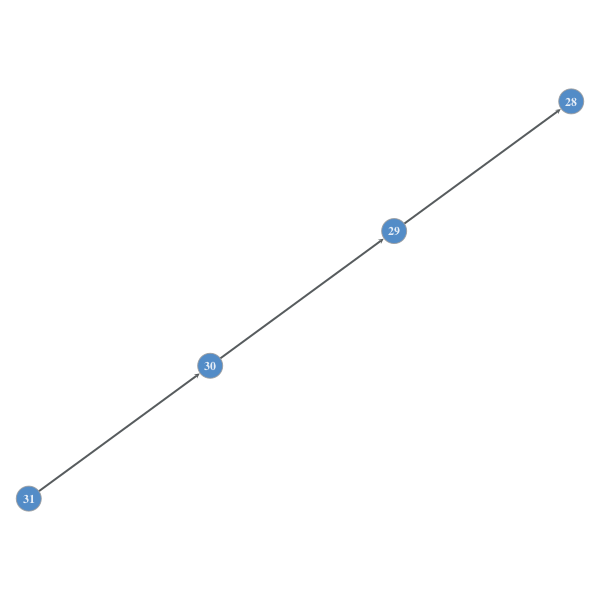

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1271f82d0, at 0x1267eb9d0>

In [158]:

gt.graph_draw(
    g, 
    vertex_text=g.vp.version, vertex_pen_width=1,  vertex_fill_color=[0x37 / 0xff, 0x78 / 0xff, 0xbf / 0xff, 0.85], 
    vertex_size=25, vertex_font_weight=1, vertex_font_size=12, edge_pen_width=2,
)

In [93]:
def get_leaves(tree):
    """
    Returns all leaves from a tree. 
    """

    for child in tree.children: 
        if not child.children:
            yield child 
        else:
            for leaf in get_leaves(child):
                yield leaf 

In [95]:
def get_depth(node):
    """
    Count the number of parents of a node.
    """
    if node is None or node == 'root':
        return 0 
    return 1 + get_depth(node.parent)
    

for node in get_leaves(ns[NAME][0]): 
    print "{}: {}".format(node.version, get_depth(node))

10: 10
12: 11
15: 13
16: 13


def num_nodes(tree):
    """
    Returns the number of nodes from a tree. 
    """
    if not tree.children: 
        return 1
    return 1 + sum(num_nodes(child) for child in tree.children)

In [109]:
num_nodes(ns[NAME][1])

49

In [163]:
def branchiness(tree):
    """
    Computes branchiness as the average shortest distance to 
    each leaf node normalized by the greatest depth.  
    """
    n = float(num_nodes(tree))
    d = [float(get_depth(leaf)) for leaf in get_leaves(tree)]
    return (sum(d) / float(len(d))) / n if d else 1.0

In [161]:
print branchiness(ns[NAME][1])

4.0
[5.0]
1.25


# Exploration of Object Space

In [153]:
for name in sorted(ns.keys()):
    name_trees = ns[name]
    num_components = len(name_trees)
    nodes = ", ".join("{}".format(num_nodes(t)) for t in name_trees)
    branches = ", ".join("{:0.3f}".format(branchiness(t)) for t in name_trees)
    
    print "{: >2}: {} components with {} nodes and {} branchiness".format(
        name, num_components, nodes, branches
    )

 A: 1 components with 6 nodes and 1.000 branchiness
AA: 2 components with 1, 30 nodes and 1.000, 0.550 branchiness
AB: 1 components with 32 nodes and 0.656 branchiness
AC: 1 components with 12 nodes and 1.000 branchiness
AD: 1 components with 12 nodes and 1.000 branchiness
AE: 1 components with 31 nodes and 0.718 branchiness
AF: 1 components with 55 nodes and 0.864 branchiness
AG: 1 components with 44 nodes and 0.648 branchiness
AH: 1 components with 17 nodes and 1.000 branchiness
AI: 1 components with 8 nodes and 1.000 branchiness
AJ: 1 components with 44 nodes and 0.568 branchiness
AK: 1 components with 12 nodes and 1.000 branchiness
AL: 2 components with 43, 13 nodes and 0.400, 0.500 branchiness
AM: 1 components with 15 nodes and 1.000 branchiness
AN: 1 components with 12 nodes and 1.000 branchiness
AO: 1 components with 26 nodes and 1.000 branchiness
AP: 1 components with 39 nodes and 0.549 branchiness
AQ: 2 components with 1, 9 nodes and 1.000, 1.111 branchiness
AR: 2 components w

In [164]:
nodes = []
bnchi = []

for tree in trees:
    ns = create_tree(tree)
    for name in sorted(ns.keys()):
        name_trees = ns[name]
        nodes += [float(num_nodes(t)) for t in name_trees]
        bnchi += [branchiness(t) for t in name_trees]
    
print "Average num nodes: {:0.2f}, Average Branchiness: {:0.3f}".format(
    sum(nodes) / float(len(nodes)), sum(bnchi) / float(len(bnchi))
)

Average num nodes: 20.03, Average Branchiness: 0.937
